# Landslide Prediction System

In [90]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#"cuda" should show up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device in use: {device}")

device in use: cuda


In [92]:
#core training parameters
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)
EPOCHS = 50
LEARNING_RATE = 1e-4
VALIDATION_RATIO = 0.2

#all valid dataset and saving directories
BASE_PATH = r"d:\Pratik\Landslide\Dataset\archive"
TRAIN_IMAGE_PATH = os.path.join(BASE_PATH, "TrainData", "img")
TRAIN_MASK_PATH = os.path.join(BASE_PATH, "TrainData", "mask")
TEST_IMAGE_PATH = os.path.join(BASE_PATH, "TestData", "img")

MODEL_PATH = r"d:\Pratik\Landslide\models\unet_landslide_torch.pth"
PREDICTION_PATH = r"d:\Pratik\Landslide\predictions_torch"

#just to makesure they exist
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
os.makedirs(PREDICTION_PATH, exist_ok=True)

In [94]:
#custom dataset class for loading landslide images and corresponding masks
class LandslideDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_files, mask_files):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = image_files
        self.mask_files = mask_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_files[index])
        mask_path = os.path.join(self.mask_dir, self.mask_files[index])
        #load hdf5 image and mask
        with h5py.File(image_path, "r") as f:
            image = f["img"][:]
        with h5py.File(mask_path, "r") as f:
            mask = f["mask"][:]

        #normalize image to 0–1 range
        min_val, max_val = image.min(), image.max()
        if max_val > min_val:
            image = (image - min_val) / (max_val - min_val)
        else:
            image = np.zeros_like(image)

        #convert to tensors and adjust dimensions
        image = torch.from_numpy(image).float().permute(2, 0, 1)  # (C, H, W)
        mask = torch.from_numpy(mask).float().unsqueeze(0)         # (1, H, W)
        return image, mask

#prepare data loaders
image_files = sorted([f for f in os.listdir(TRAIN_IMAGE_PATH) if f.endswith(".h5")])
mask_files = sorted([f for f in os.listdir(TRAIN_MASK_PATH) if f.endswith(".h5")])

train_images, valid_images, train_masks, valid_masks = train_test_split(
    image_files, mask_files, test_size = VALIDATION_RATIO, random_state = 42)

train_dataset = LandslideDataset(TRAIN_IMAGE_PATH, TRAIN_MASK_PATH, train_images, train_masks)
valid_dataset = LandslideDataset(TRAIN_IMAGE_PATH, TRAIN_MASK_PATH, valid_images, valid_masks)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

loading batch from training data:


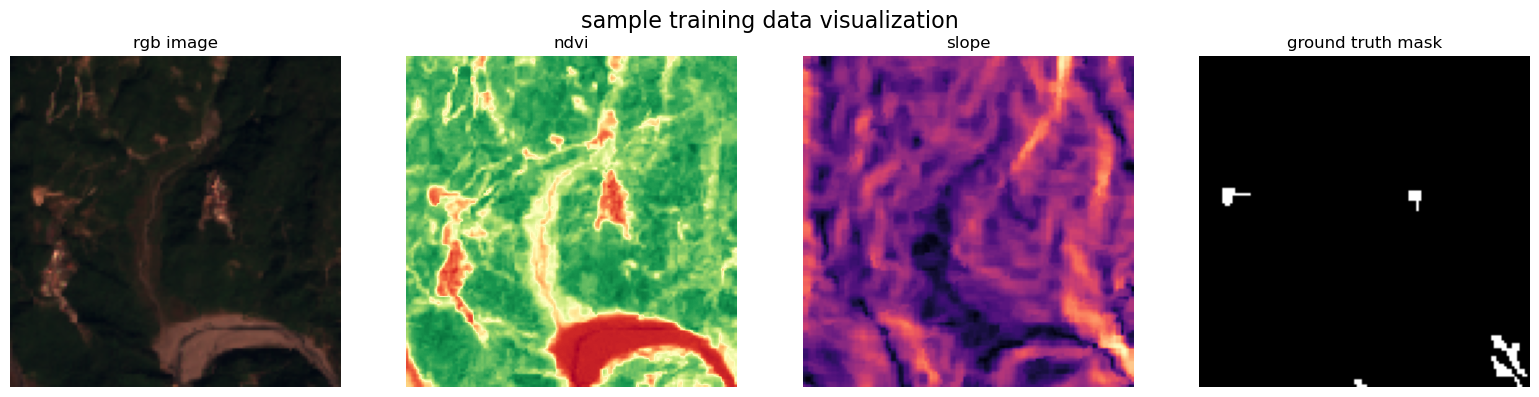

input tensor shape: torch.Size([14, 128, 128]) (channels, height, width)
mask tensor shape: torch.Size([1, 128, 128]) (0, 1)
data range: min = 0.00, max = 1.00  <-- (normalized)


In [134]:
#inspect 1 sample batch before processing
#this helps us verify our original data is processed and normalized correctly

print("loading batch from training data:")
sample_images, sample_masks = next(iter(train_loader))

#pick the first sample for visualization
image_tensor = sample_images[0]
mask_tensor = sample_masks[0]

#tensorts -> numpy arrays
image_np = image_tensor.cpu().numpy()
mask_np = mask_tensor.cpu().numpy().squeeze()

#extract bands
red_band = image_np[3, :, :]
nir_band = image_np[7, :, :]
rgb_image = image_np[[3, 2, 1], :, :].transpose(1, 2, 0)
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
'''
plt.imshow(image_np[13, :, :], cmap="terrain")
plt.title("Elevation Band")
plt.show()
'''
#compute NDVI
ndvi_map = (nir_band - red_band) / (nir_band + red_band + 1e-7)

#slope band
slope_map = image_np[12, :, :]

#visualize all the reprsentations which we got
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(rgb_image)
axes[0].set_title("rgb image")
axes[0].axis("off")

axes[1].imshow(ndvi_map, cmap="RdYlGn")
axes[1].set_title("ndvi")
axes[1].axis("off")

axes[2].imshow(slope_map, cmap="magma")
axes[2].set_title("slope")
axes[2].axis("off")

axes[3].imshow(mask_np, cmap="gray")
axes[3].set_title("ground truth mask")
axes[3].axis("off")

plt.suptitle("sample training data visualization", fontsize=16)
plt.tight_layout()
plt.show()

print(f"input tensor shape: {image_tensor.shape} (channels, height, width)")
print(f"mask tensor shape: {mask_tensor.shape} (0, 1)")
print(f"data range: min = {image_np.min():.2f}, max = {image_np.max():.2f}  <-- (normalized)")

In [124]:
#unet architecture definition
class DoubleConv(nn.Module):
    #2 consecutive CL followed by ReLU activations"
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.sequence = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.sequence(x)

class UNet(nn.Module):
    #standard unet model for binary segmentation
    def __init__(self, in_channels=14, out_channels=1):
        super().__init__()

        #encoder(contracting path)
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        #pooling and upsampling layers
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

        #decoder(expanding path)
        self.up3 = DoubleConv(256 + 512, 256)
        self.up2 = DoubleConv(128 + 256, 128)
        self.up1 = DoubleConv(64 + 128, 64)

        #1x1 convolution for final output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        #encoding path
        c1 = self.down1(x)
        x = self.pool(c1)

        c2 = self.down2(x)
        x = self.pool(c2)

        c3 = self.down3(x)
        x = self.pool(c3)

        #bottleneck
        x = self.down4(x)

        #decoding path with skip connections
        x = self.upsample(x)
        x = torch.cat([x, c3], dim=1)
        x = self.up3(x)

        x = self.upsample(x)
        x = torch.cat([x, c2], dim=1)
        x = self.up2(x)

        x = self.upsample(x)
        x = torch.cat([x, c1], dim=1)
        x = self.up1(x)

        #final sigmoid activation for binary segmentation
        return torch.sigmoid(self.final_conv(x))

In [108]:
#loss func and other calculations
class DiceLoss(nn.Module):
    #dice loss for segmentaion accuracy
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        intersection = (preds * targets).sum()
        union = preds.sum() + targets.sum()
        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_score


def calculate_metrics(preds, targets):
    #calculate tp, fp and fn
    preds = (preds > 0.5).float()
    tp = (targets * preds).sum().item()
    fp = ((1 - targets) * preds).sum().item()
    fn = (targets * (1 - preds)).sum().item()
    return tp, fp, fn

def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    """runs one training epoch and computes performance metrics"""
    model.train()
    total_loss = 0
    total_tp, total_fp, total_fn = 0, 0, 0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        tp, fp, fn = calculate_metrics(outputs, masks)
        total_tp += tp
        total_fp += fp
        total_fn += fn

    precision = total_tp / (total_tp + total_fp + 1e-7)
    recall = total_tp / (total_tp + total_fn + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

    return total_loss / len(dataloader), precision, recall, f1

def validate_one_epoch(model, dataloader, loss_fn, device):
    """evaluates the model on validation data"""
    model.eval()
    total_loss = 0
    total_tp, total_fp, total_fn = 0, 0, 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            total_loss += loss.item()

            tp, fp, fn = calculate_metrics(outputs, masks)
            total_tp += tp
            total_fp += fp
            total_fn += fn

    precision = total_tp / (total_tp + total_fp + 1e-7)
    recall = total_tp / (total_tp + total_fn + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

    return total_loss / len(dataloader), precision, recall, f1


starting model training...
epoch 1/50 - train loss: 0.7719, val loss: 0.5392 (saved)
epoch 2/50 - train loss: 0.4621, val loss: 0.4129 (saved)
epoch 3/50 - train loss: 0.4130, val loss: 0.3656 (saved)
epoch 4/50 - train loss: 0.3672, val loss: 0.3497 (saved)
epoch 5/50 - train loss: 0.3435, val loss: 0.3177 (saved)
epoch 6/50 - train loss: 0.3307, val loss: 0.3506
epoch 7/50 - train loss: 0.3374, val loss: 0.2998 (saved)
epoch 8/50 - train loss: 0.3177, val loss: 0.2964 (saved)
epoch 9/50 - train loss: 0.3134, val loss: 0.2938 (saved)
epoch 10/50 - train loss: 0.3102, val loss: 0.2903 (saved)
epoch 11/50 - train loss: 0.3031, val loss: 0.2784 (saved)
epoch 12/50 - train loss: 0.3013, val loss: 0.2840
epoch 13/50 - train loss: 0.2970, val loss: 0.2934
epoch 14/50 - train loss: 0.2925, val loss: 0.2764 (saved)
epoch 15/50 - train loss: 0.2981, val loss: 0.2788
epoch 16/50 - train loss: 0.2951, val loss: 0.2685 (saved)
epoch 17/50 - train loss: 0.2914, val loss: 0.2753
epoch 18/50 - train

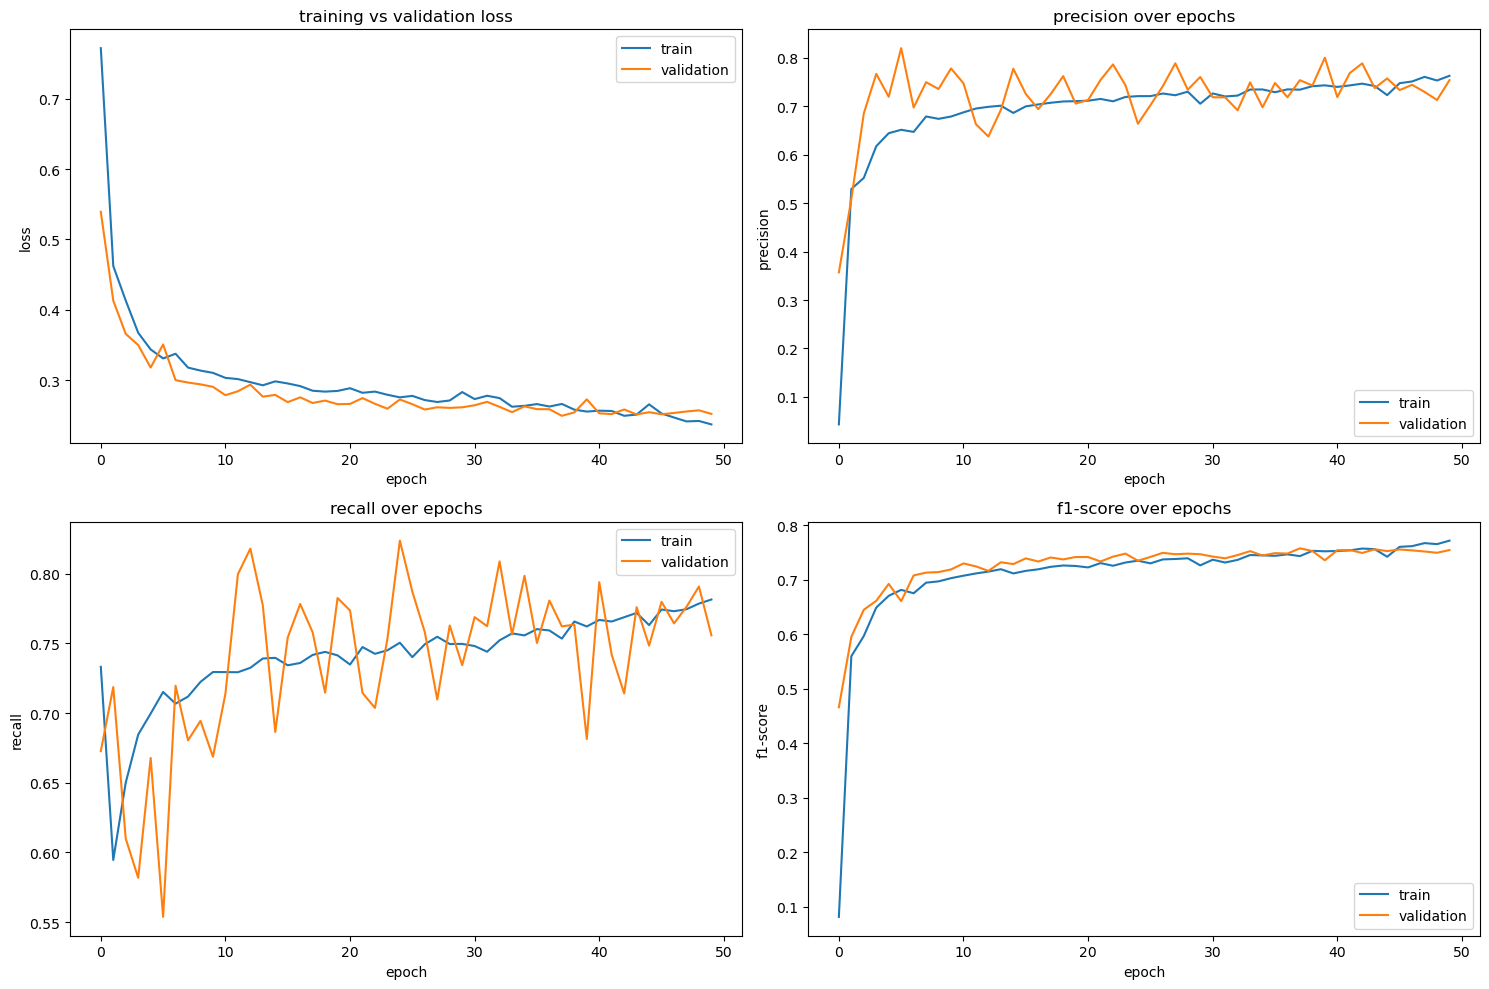

In [110]:
#model training loop and performance visualization
model = UNet(in_channels=14, out_channels=1).to(device)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# initialize training history to track metrics
history = {
    "train_loss": [], "val_loss": [],
    "train_precision": [], "val_precision": [],
    "train_recall": [], "val_recall": [],
    "train_f1": [], "val_f1": []
}

FORCE_TRAIN = True  #set False to use previously trained

if FORCE_TRAIN or not os.path.exists(MODEL_PATH):
    print("starting model training...")
    best_val_loss = float("inf")

    for epoch in range(EPOCHS):
        train_loss, train_prec, train_rec, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_prec, val_rec, val_f1 = validate_one_epoch(model, valid_loader, criterion, device)

        # update training history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_precision"].append(train_prec)
        history["val_precision"].append(val_prec)
        history["train_recall"].append(train_rec)
        history["val_recall"].append(val_rec)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(val_f1)

        # save model if validation improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"epoch {epoch + 1}/{EPOCHS} - train loss: {train_loss:.4f}, val loss: {val_loss:.4f} (saved)")
        else:
            print(f"epoch {epoch + 1}/{EPOCHS} - train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")

    # plot metric trends over epochs
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # loss plot
    axes[0, 0].plot(history["train_loss"], label="train")
    axes[0, 0].plot(history["val_loss"], label="validation")
    axes[0, 0].set_title("training vs validation loss")
    axes[0, 0].set_xlabel("epoch")
    axes[0, 0].set_ylabel("loss")
    axes[0, 0].legend()

    # precision plot
    axes[0, 1].plot(history["train_precision"], label="train")
    axes[0, 1].plot(history["val_precision"], label="validation")
    axes[0, 1].set_title("precision over epochs")
    axes[0, 1].set_xlabel("epoch")
    axes[0, 1].set_ylabel("precision")
    axes[0, 1].legend()

    # recall plot
    axes[1, 0].plot(history["train_recall"], label="train")
    axes[1, 0].plot(history["val_recall"], label="validation")
    axes[1, 0].set_title("recall over epochs")
    axes[1, 0].set_xlabel("epoch")
    axes[1, 0].set_ylabel("recall")
    axes[1, 0].legend()

    # f1-score plot
    axes[1, 1].plot(history["train_f1"], label="train")
    axes[1, 1].plot(history["val_f1"], label="validation")
    axes[1, 1].set_title("f1-score over epochs")
    axes[1, 1].set_xlabel("epoch")
    axes[1, 1].set_ylabel("f1-score")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(PREDICTION_PATH, "training_metrics.png"))
    plt.show()

else:
    print("=" * 40)
    print(f"found pretrained model at: {MODEL_PATH}")
    print("skipping training and loading existing weights.")
    print("=" * 40)
    model.load_state_dict(torch.load(MODEL_PATH))

In [114]:
# evaluate model performance across the full validation set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# load the trained model and prepare it for evaluation
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

print("evaluating model on validation dataset...")

# initialize accumulators for all evaluation statistics
total_tp, total_fp, total_fn, total_tn = 0, 0, 0, 0
total_intersection, total_union = 0, 0

with torch.no_grad():
    for images, masks in valid_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        predictions = (outputs > 0.5).float()

        # flatten for metric computation
        y_true = masks.view(-1)
        y_pred = predictions.view(-1)

        # confusion matrix components
        tp = (y_true * y_pred).sum().item()
        tn = ((1 - y_true) * (1 - y_pred)).sum().item()
        fp = ((1 - y_true) * y_pred).sum().item()
        fn = (y_true * (1 - y_pred)).sum().item()

        total_tp += tp
        total_tn += tn
        total_fp += fp
        total_fn += fn

        # intersection-over-union statistics
        intersection = (y_true * y_pred).sum().item()
        union = y_true.sum().item() + y_pred.sum().item() - intersection
        total_intersection += intersection
        total_union += union

# aggregate performance metrics
precision = total_tp / (total_tp + total_fp + 1e-7)
recall = total_tp / (total_tp + total_fn + 1e-7)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
iou = total_intersection / (total_union + 1e-7)
accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)

# print results in a clear summary
print("aggregate evaluation metrics")
print(f"mean IoU:       {iou:.4f}")
print(f"mean F1-score:  {f1:.4f}")
print(f"mean precision: {precision:.4f}")
print(f"mean recall:    {recall:.4f}")
print(f"mean accuracy:  {accuracy:.4f}")

#confustion matrix visuals
'''
cm = np.array([[total_tn, total_fp], [total_fn, total_tp]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-landslide", "landslide"])
disp.plot(cmap="Blues", values_format=".0f")
plt.title("global confusion matrix (pixel-level)")
plt.savefig(os.path.join(PREDICTION_PATH, "confusion_matrix.png"))
plt.show()
'''

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35528\1630554059.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


evaluating model on validation dataset...
aggregate evaluation metrics
mean IoU:       0.6102
mean F1-score:  0.7579
mean precision: 0.7536
mean recall:    0.7622
mean accuracy:  0.9880


'\ncm = np.array([[total_tn, total_fp], [total_fn, total_tp]])\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-landslide", "landslide"])\ndisp.plot(cmap="Blues", values_format=".0f")\nplt.title("global confusion matrix (pixel-level)")\nplt.savefig(os.path.join(PREDICTION_PATH, "confusion_matrix.png"))\nplt.show()\n'

generating random visual samples...


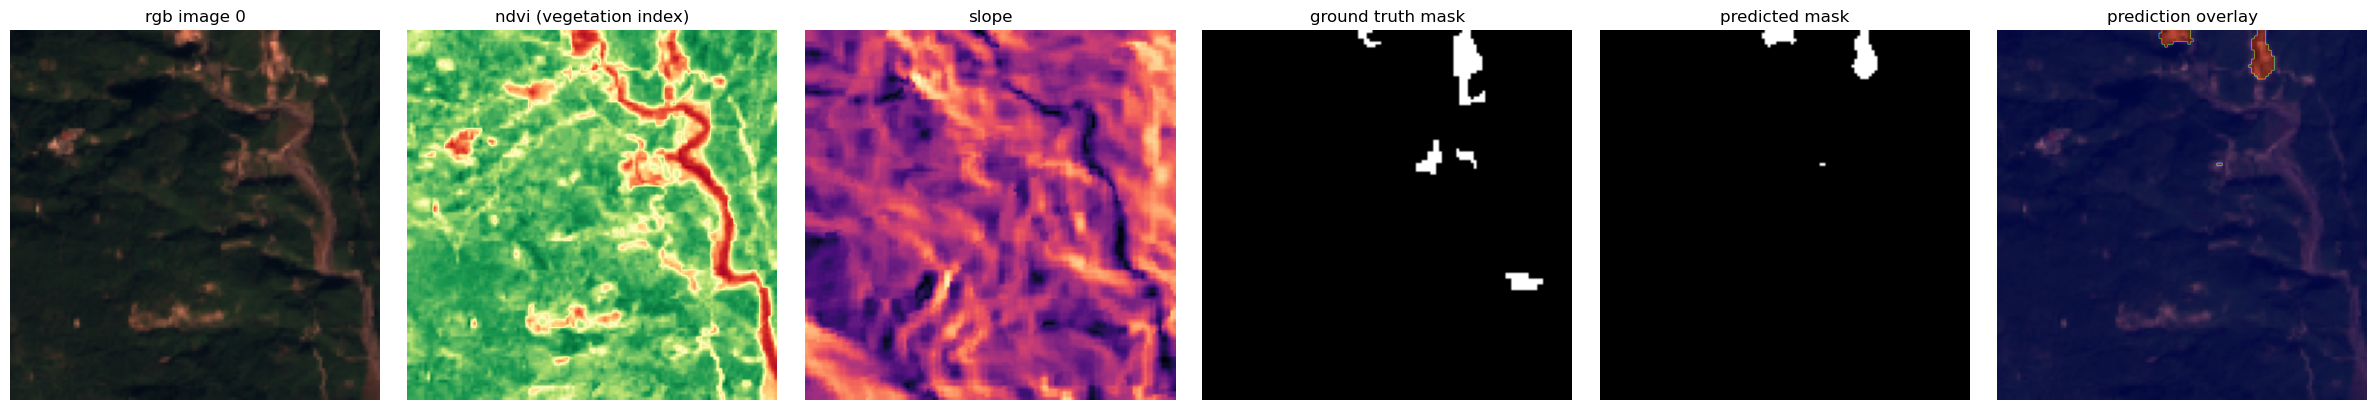

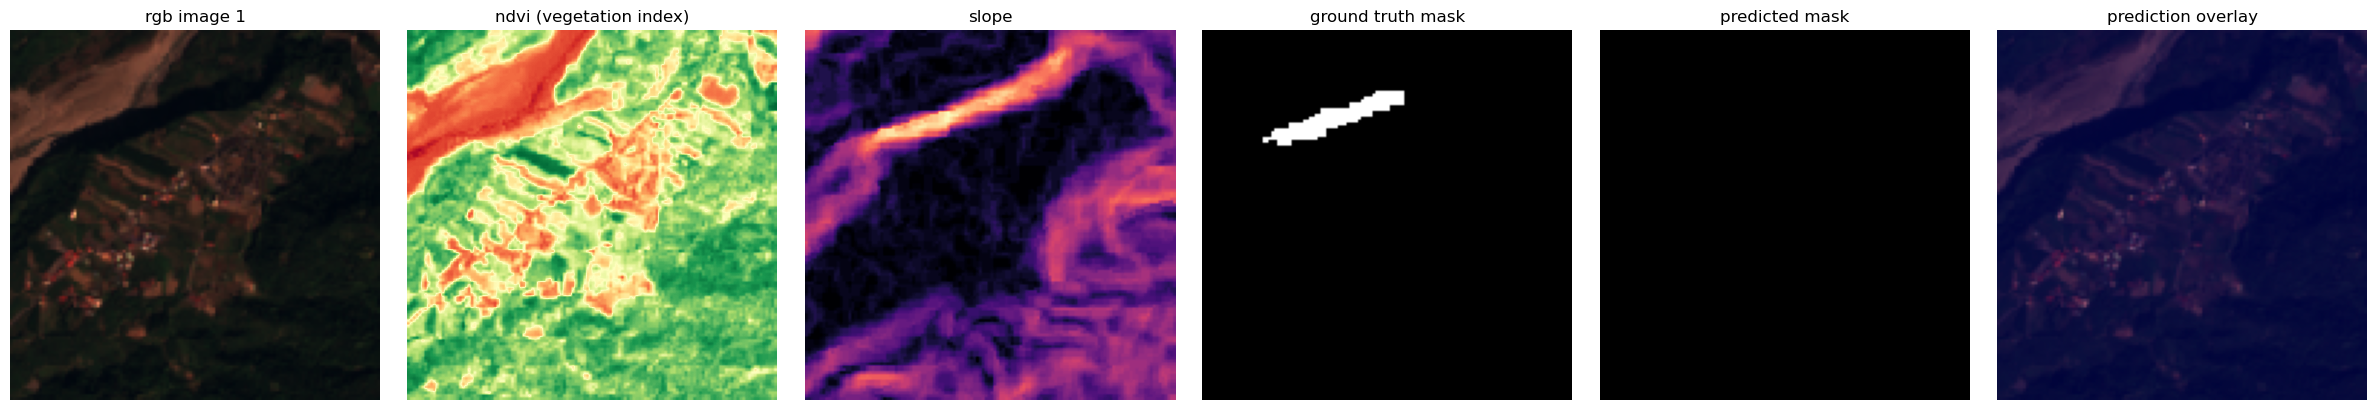

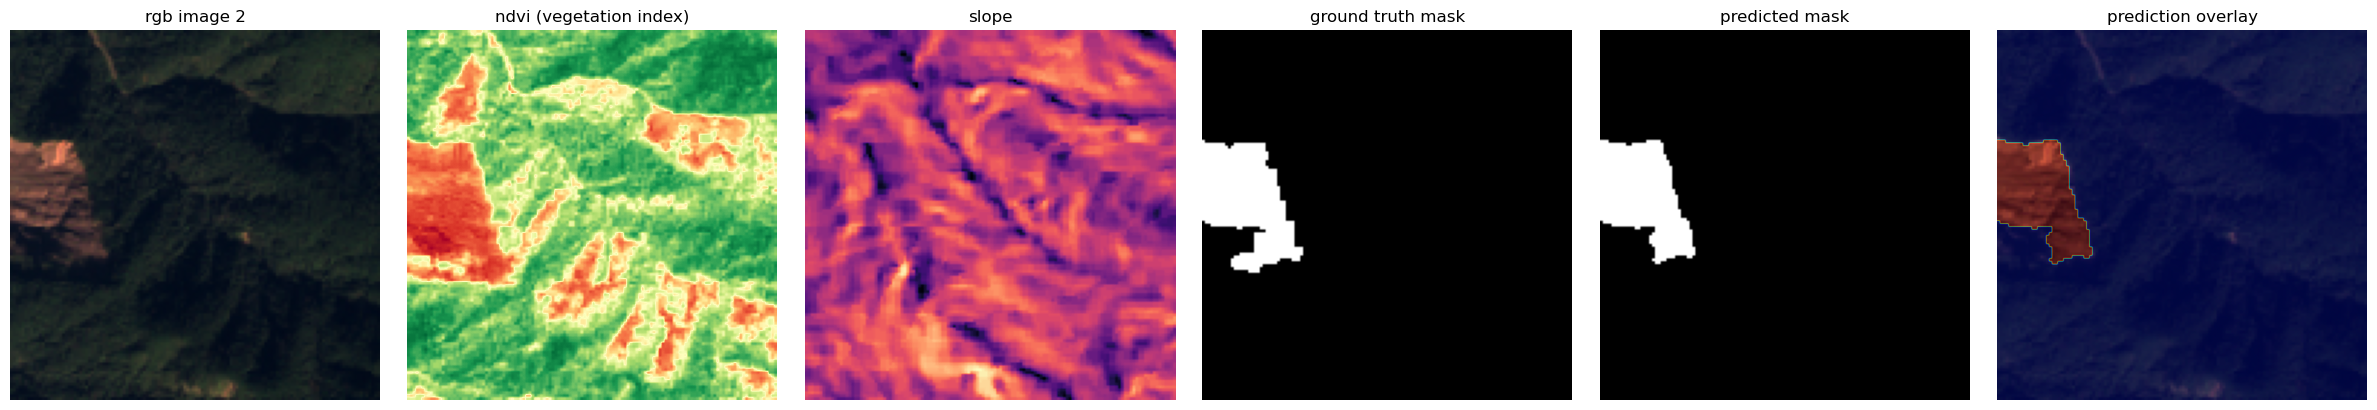

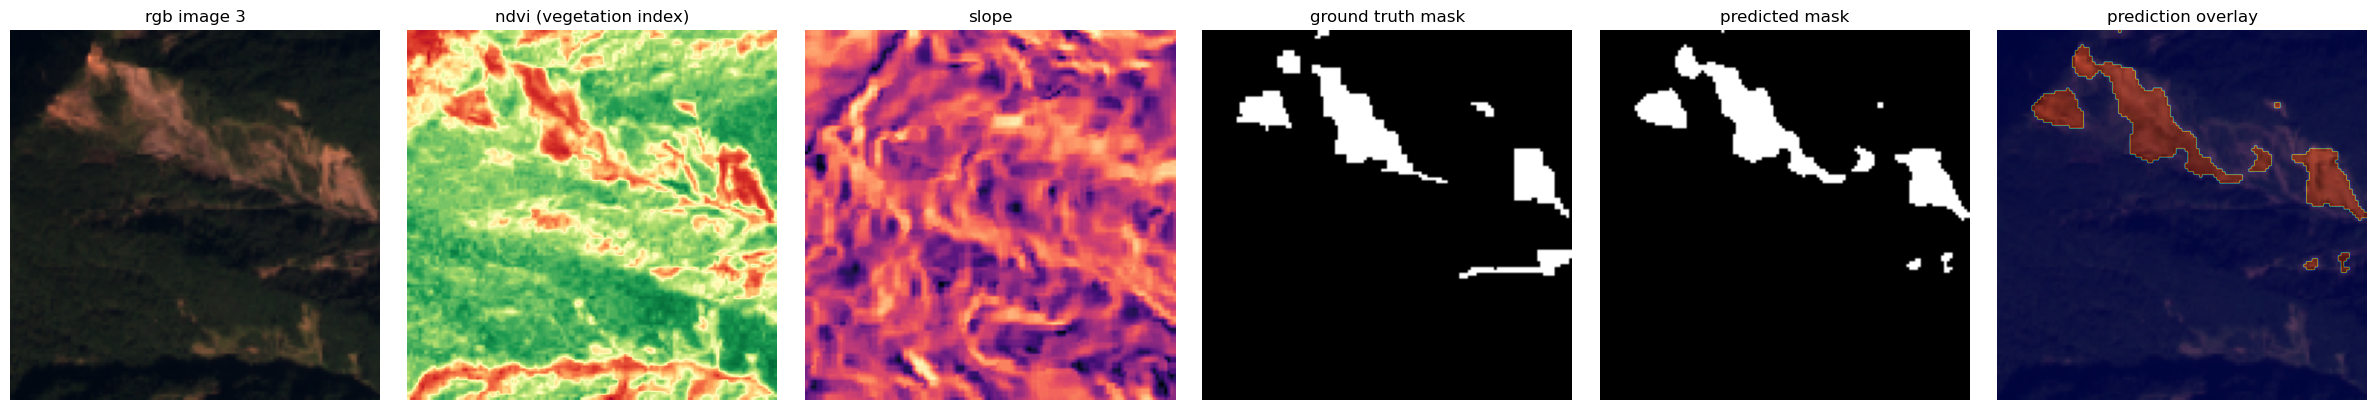

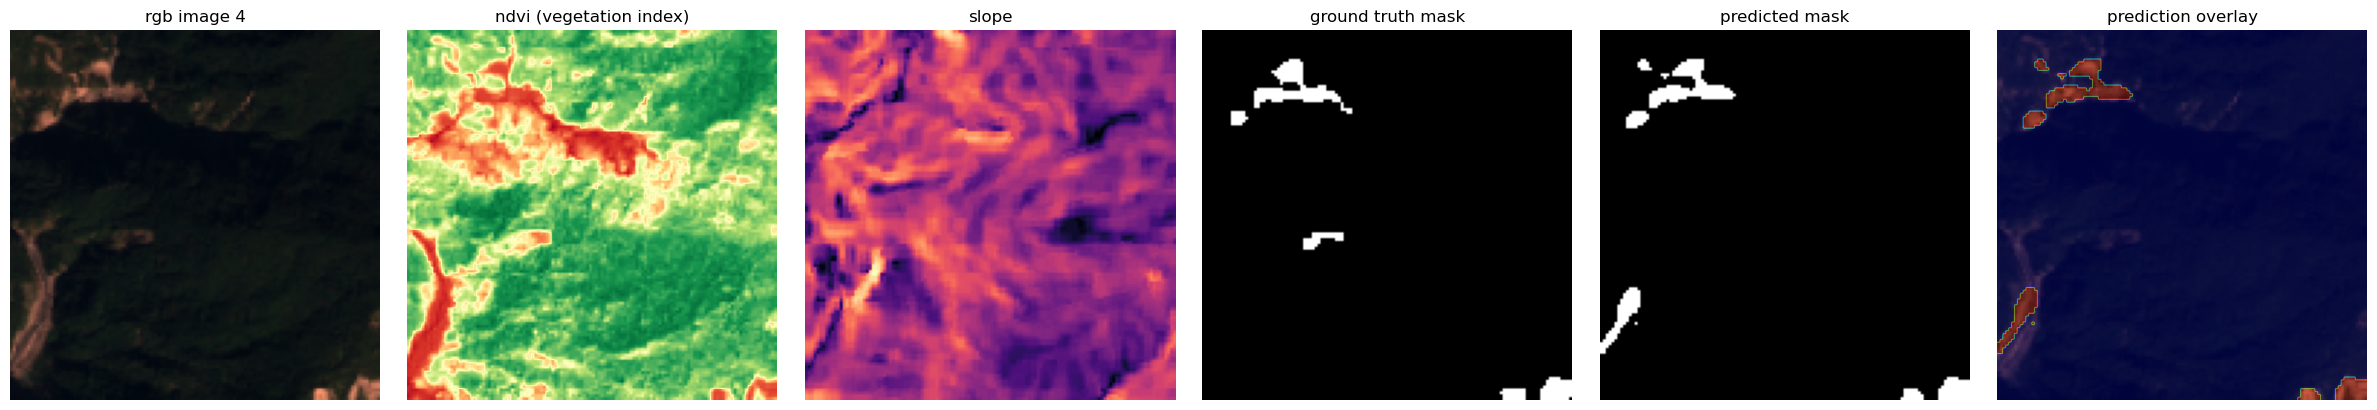

random report images and predictions saved to: d:\Pratik\Landslide\predictions_torch


In [120]:
# visualization and qualitative report generation
def visualize_sample(image_tensor, mask_tensor, prediction_tensor, index):
    """visualize sample results, including input, ndvi, terrain, and prediction"""

    # convert tensors to numpy arrays
    image = image_tensor.cpu().numpy()  # (14, 128, 128)
    mask = mask_tensor.cpu().numpy().squeeze()
    prediction = prediction_tensor.cpu().numpy().squeeze()

    # extract key spectral bands
    red = image[3, :, :]
    nir = image[7, :, :]
    rgb = image[[3, 2, 1], :, :].transpose(1, 2, 0)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

    # compute ndvi
    ndvi = (nir - red) / (nir + red + 1e-7)

    # extract terrain information
    slope = image[12, :, :]
    elevation = image[13, :, :]

    # plot visualization grid
    fig, axes = plt.subplots(1, 6, figsize=(24, 4))

    axes[0].imshow(rgb)
    axes[0].set_title(f"rgb image {index}")
    axes[0].axis("off")

    axes[1].imshow(ndvi, cmap="RdYlGn")
    axes[1].set_title("ndvi (vegetation index)")
    axes[1].axis("off")

    axes[2].imshow(slope, cmap="magma")
    axes[2].set_title("slope")
    axes[2].axis("off")

    axes[3].imshow(mask, cmap="gray")
    axes[3].set_title("ground truth mask")
    axes[3].axis("off")

    axes[4].imshow(prediction, cmap="gray")
    axes[4].set_title("predicted mask")
    axes[4].axis("off")

    axes[5].imshow(rgb)
    axes[5].imshow(prediction, cmap="jet", alpha=0.4)
    axes[5].set_title("prediction overlay")
    axes[5].axis("off")

    plt.tight_layout()
    plt.savefig(os.path.join(PREDICTION_PATH, f"sample_{index}_report.png"))
    plt.show()

    # save raw prediction array
    np.save(os.path.join(PREDICTION_PATH, f"pred_mask_{index}.npy"), prediction)


# generate qualitative report for a few validation samples
import random

model.eval()
print("generating random visual samples...")

# pick 5 random indices from validation dataset
random_indices = random.sample(range(len(valid_dataset)), 5)

with torch.no_grad():
    for i, idx in enumerate(random_indices):
        image, mask = valid_dataset[idx]
        image = image.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)

        output = model(image)
        pred = (output > 0.5).float()

        visualize_sample(image[0].cpu(), mask[0].cpu(), pred[0].cpu(), i)

print(f"random report images and predictions saved to: {PREDICTION_PATH}")